# Ch0 | 极速上手：极速手搓神经网络

---

**核心理念：** 快速亲自构建神经网络

---

## 本章目标

别管原理，先让代码跑起来，亲眼看到机器学会分类。

**痛点解决：** "深度学习代码到底长什么样？"

## 本章内容

1. **数据构造**：用 sklearn 生成经典的"螺旋图"数据（红蓝两类点交错，线性不可分）
2. **搭建网络**：直接用 `torch.nn.Sequential` 堆一个 MLP（多层感知机）
3. **训练循环**：写出标准的 `Forward -> Loss -> Backward -> Step` 循环
4. **可视化**：观察神经网络如何学会划分边界

---

## 🎓 本课程适合谁？

### 目标读者

这门课程适合：
- 想**深入理解** LLM 原理的开发者
- 已经会用 API 调用 LLM，但想知道**背后发生了什么**的人
- 想**从零构建** LLM 的学习者

### 前置要求

- **Python 基础**：函数、类、列表等
- **基本数学**：向量、矩阵乘法（不需要精通）
- **PyTorch 入门**：能写简单的 tensor 操作（课程会复习）

### 不需要

- 不需要深厚的数学功底
- 不需要有机器学习经验
- 不需要 GPU（大部分代码 CPU 能跑）

### 课程特色

1. **代码优先**：每个概念都有可运行的代码
2. **可视化**：大量图表帮助理解
3. **循序渐进**：从最简单的概念开始
4. **实战导向**：最终能训练自己的小模型

### 本章目标

快速过一遍核心概念，让你对整个课程有个全局认识！

## 0. 环境准备

首先安装并导入必要的库。

In [ ]:
# 如果需要安装依赖，取消下面的注释
# !pip install torch numpy matplotlib scikit-learn

# 确认README中的依赖是否完毕安装， torch版本请根据实际环境选择，根据readme中的指引安装
!pip install -r ../requirements.txt

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles

# 设置随机种子，保证结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 设置中文字体（如果需要显示中文）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu128
CUDA available: True


---

## 1. 数据构造：生成一个"线性不可分"的经典问题

我们使用 sklearn 生成一个经典的 **月亮形数据集 (make_moons)**。

这个数据集的特点是：
- 两类数据点交错排列
- **无法用一条直线分开**（线性不可分）
- 这正是神经网络大显身手的地方！

### 为什么选择这个数据集？

如果数据是线性可分的（比如两团分开的点），一条直线就能搞定，用不着神经网络。
月亮形数据需要**弯曲的决策边界**，这正好展示了神经网络的威力。

In [2]:
# 生成月亮形数据集
n_samples = 1000

X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=42)

# 转换为 PyTorch 张量
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).reshape(-1, 1)  # 变成列向量

print(f"数据形状: X={X_tensor.shape}, y={y_tensor.shape}")
print(f"特征维度: {X_tensor.shape[1]} (x坐标, y坐标)")
print(f"类别: {torch.unique(y_tensor).tolist()} (0=蓝色, 1=红色)")

数据形状: X=torch.Size([1000, 2]), y=torch.Size([1000, 1])
特征维度: 2 (x坐标, y坐标)
类别: [0.0, 1.0] (0=蓝色, 1=红色)


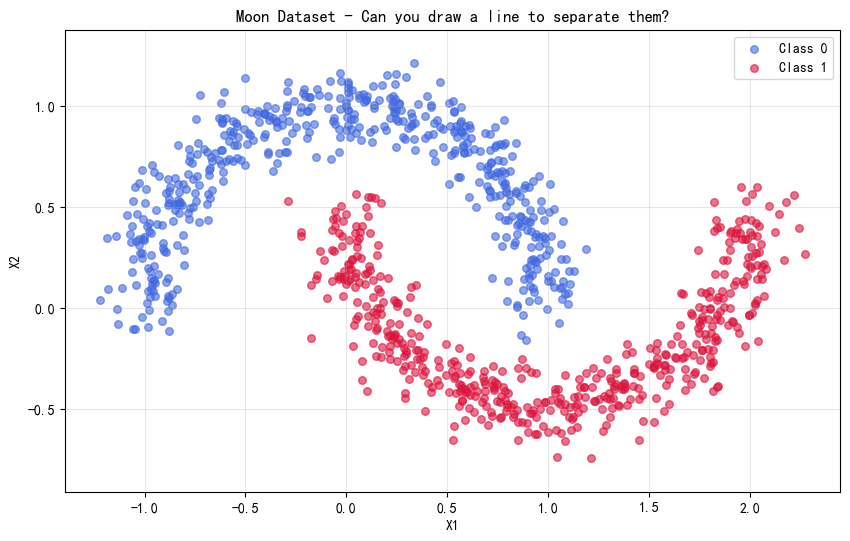


思考：你能用一条直线把蓝色和红色分开吗？
答案：不能！这就是为什么我们需要神经网络。


In [3]:
# 可视化原始数据
plt.figure(figsize=(10, 6))

# 分别绘制两类点
plt.scatter(X[y==0, 0], X[y==0, 1], c='royalblue', label='Class 0', alpha=0.6, s=30)
plt.scatter(X[y==1, 0], X[y==1, 1], c='crimson', label='Class 1', alpha=0.6, s=30)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Moon Dataset - Can you draw a line to separate them?')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

print("\n思考：你能用一条直线把蓝色和红色分开吗？")
print("答案：不能！这就是为什么我们需要神经网络。")

---

## 2. 搭建神经网络：MLP (多层感知机)

MLP 就是最基础的神经网络，由多层**全连接层**堆叠而成。

### 网络结构

```
输入层 (2个神经元) → 隐藏层1 (32个神经元) → 隐藏层2 (16个神经元) → 输出层 (1个神经元)
      ↓                    ↓                    ↓                    ↓
   [x1, x2]              ReLU                 ReLU               Sigmoid
                                                                    ↓
                                                              概率值 (0~1)
```

### 关键概念

- **全连接层 (Linear)**：每个神经元和上一层所有神经元相连
- **ReLU 激活函数**：引入非线性，让网络能学习复杂边界
- **Sigmoid**：把输出压缩到 0~1 之间，表示概率

In [4]:
# 定义神经网络模型
model = nn.Sequential(
    nn.Linear(2, 32),    # 输入层 -> 隐藏层1: 2维输入，32个神经元
    nn.ReLU(),           # 激活函数: max(0, x)
    nn.Linear(32, 16),   # 隐藏层1 -> 隐藏层2: 32个神经元 -> 16个神经元
    nn.ReLU(),           # 激活函数
    nn.Linear(16, 1),    # 隐藏层2 -> 输出层: 16个神经元 -> 1个输出
    nn.Sigmoid()         # 输出概率 (0~1)
)

print("模型结构:")
print(model)

# 统计参数数量
total_params = sum(p.numel() for p in model.parameters())
print(f"\n总参数量: {total_params}")

模型结构:
Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

总参数量: 641


In [5]:
# 让我们看看模型内部的参数
print("模型参数详情:")
print("=" * 50)

for name, param in model.named_parameters():
    print(f"{name}:")
    print(f"  形状: {param.shape}")
    print(f"  参数量: {param.numel()}")
    print()

模型参数详情:
0.weight:
  形状: torch.Size([32, 2])
  参数量: 64

0.bias:
  形状: torch.Size([32])
  参数量: 32

2.weight:
  形状: torch.Size([16, 32])
  参数量: 512

2.bias:
  形状: torch.Size([16])
  参数量: 16

4.weight:
  形状: torch.Size([1, 16])
  参数量: 16

4.bias:
  形状: torch.Size([1])
  参数量: 1



### 理解参数数量

| 层 | 计算 | 参数量 |
|:---|:---|:---|
| Linear(2→32) | 2×32 + 32(bias) | 96 |
| Linear(32→16) | 32×16 + 16(bias) | 528 |
| Linear(16→1) | 16×1 + 1(bias) | 17 |
| **总计** | | **641** |

这就是神经网络的本质：**一堆可学习的数字（权重）**。

训练的目标就是调整这641个数字，让网络能正确分类。

---

## 3. 训练循环：Forward → Loss → Backward → Step

这是深度学习最核心的四步循环，记住它！

```
┌─────────────────────────────────────────────────────────────┐
│                                                             │
│   1. Forward (前向传播)                                      │
│      输入数据 → 经过网络 → 得到预测结果                        │
│                         ↓                                   │
│   2. Loss (计算损失)                                         │
│      预测结果 vs 真实标签 → 计算差距有多大                     │
│                         ↓                                   │
│   3. Backward (反向传播)                                     │
│      计算每个参数对 Loss 的贡献（梯度）                        │
│                         ↓                                   │
│   4. Step (更新参数)                                         │
│      根据梯度调整参数，让 Loss 变小                           │
│                         ↓                                   │
│                    回到第1步                                 │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

In [6]:
# 定义损失函数和优化器

# BCE Loss: Binary Cross Entropy，二分类的标准损失函数
criterion = nn.BCELoss()

# Adam 优化器: 目前最常用的优化器
# lr = learning rate (学习率): 每次更新参数的步长
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("损失函数: Binary Cross Entropy (BCE)")
print("优化器: Adam")
print("学习率: 0.01")

损失函数: Binary Cross Entropy (BCE)
优化器: Adam
学习率: 0.01


In [7]:
# 训练循环 - 核心代码！

epochs = 500  # 训练轮数
losses = []   # 记录每轮的损失

print("开始训练...")
print("=" * 50)

for epoch in range(epochs):
    # ========== 1. Forward: 前向传播 ==========
    y_pred = model(X_tensor)  # 输入数据，得到预测
    
    # ========== 2. Loss: 计算损失 ==========
    loss = criterion(y_pred, y_tensor)  # 预测值 vs 真实值
    losses.append(loss.item())
    
    # ========== 3. Backward: 反向传播 ==========
    optimizer.zero_grad()  # 清空上一轮的梯度（重要！）
    loss.backward()        # 计算梯度
    
    # ========== 4. Step: 更新参数 ==========
    optimizer.step()       # 根据梯度更新参数
    
    # 每100轮打印一次
    if (epoch + 1) % 100 == 0:
        # 计算准确率
        with torch.no_grad():
            predicted = (y_pred > 0.5).float()
            accuracy = (predicted == y_tensor).sum() / len(y_tensor) * 100
        print(f"Epoch [{epoch+1:3d}/{epochs}] | Loss: {loss.item():.4f} | Accuracy: {accuracy:.1f}%")

print("=" * 50)
print("训练完成!")

开始训练...
Epoch [100/500] | Loss: 0.0099 | Accuracy: 100.0%
Epoch [200/500] | Loss: 0.0024 | Accuracy: 100.0%
Epoch [300/500] | Loss: 0.0012 | Accuracy: 100.0%
Epoch [400/500] | Loss: 0.0007 | Accuracy: 100.0%
Epoch [500/500] | Loss: 0.0005 | Accuracy: 100.0%
训练完成!


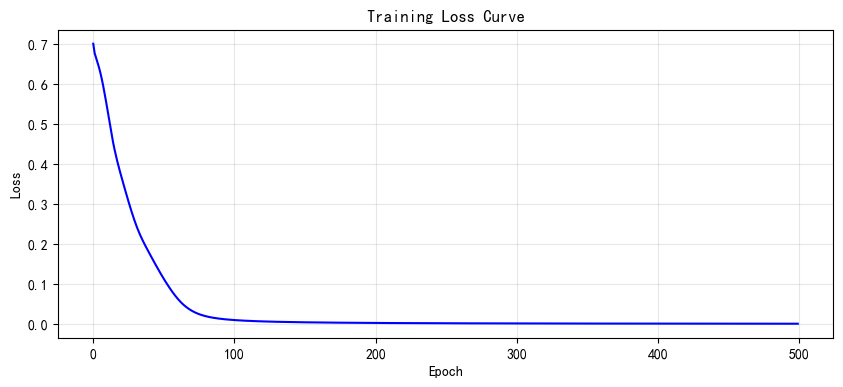

初始 Loss: 0.7003
最终 Loss: 0.0005
Loss 下降了: 99.9%


In [8]:
# 可视化训练过程：Loss 下降曲线

plt.figure(figsize=(10, 4))
plt.plot(losses, color='blue', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True, alpha=0.3)
plt.show()

print(f"初始 Loss: {losses[0]:.4f}")
print(f"最终 Loss: {losses[-1]:.4f}")
print(f"Loss 下降了: {(1 - losses[-1]/losses[0])*100:.1f}%")

---

## 4. 可视化决策边界：见证奇迹的时刻！

现在让我们看看训练好的神经网络是如何划分边界的。

我们会在整个平面上密集采样点，让模型预测每个点的类别，然后画出**决策边界**。

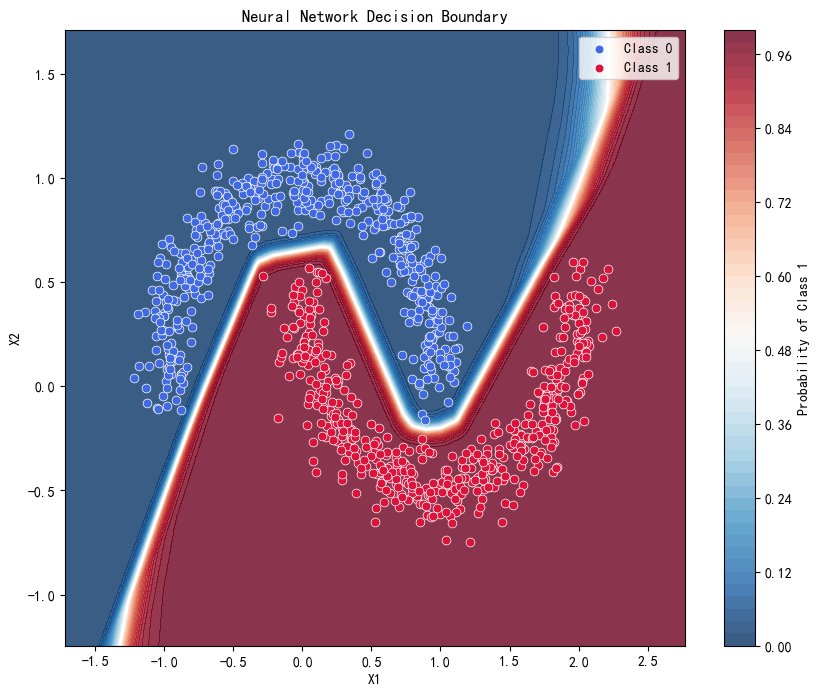

In [9]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """
    绘制决策边界
    """
    # 创建网格点
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    
    # 预测网格上每个点的类别
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = model(grid_points).numpy().reshape(xx.shape)
    
    # 绘图
    plt.figure(figsize=(10, 8))
    
    # 画决策边界（填充颜色）
    plt.contourf(xx, yy, Z, levels=50, cmap='RdBu_r', alpha=0.8)
    plt.colorbar(label='Probability of Class 1')
    
    # 画决策边界线 (概率=0.5的等高线)
    plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=2)
    
    # 画数据点
    plt.scatter(X[y==0, 0], X[y==0, 1], c='royalblue', edgecolors='white', 
                label='Class 0', s=40, linewidths=0.5)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='crimson', edgecolors='white', 
                label='Class 1', s=40, linewidths=0.5)
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

# 绘制决策边界
plot_decision_boundary(model, X, y, title="Neural Network Decision Boundary")

In [10]:
# 最终模型评估

with torch.no_grad():
    y_pred = model(X_tensor)
    predicted_labels = (y_pred > 0.5).float()
    accuracy = (predicted_labels == y_tensor).sum() / len(y_tensor) * 100

print("="*50)
print("模型最终评估")
print("="*50)
print(f"准确率: {accuracy:.2f}%")
print(f"正确分类: {int((predicted_labels == y_tensor).sum())}/{len(y_tensor)}")
print(f"错误分类: {int((predicted_labels != y_tensor).sum())}/{len(y_tensor)}")

模型最终评估
准确率: 100.00%
正确分类: 1000/1000
错误分类: 0/1000


---

## 5. 动态可视化：观察网络如何"学习"边界

让我们重新训练，这次每隔一段时间保存一下决策边界，看看网络是如何逐步学会划分的。

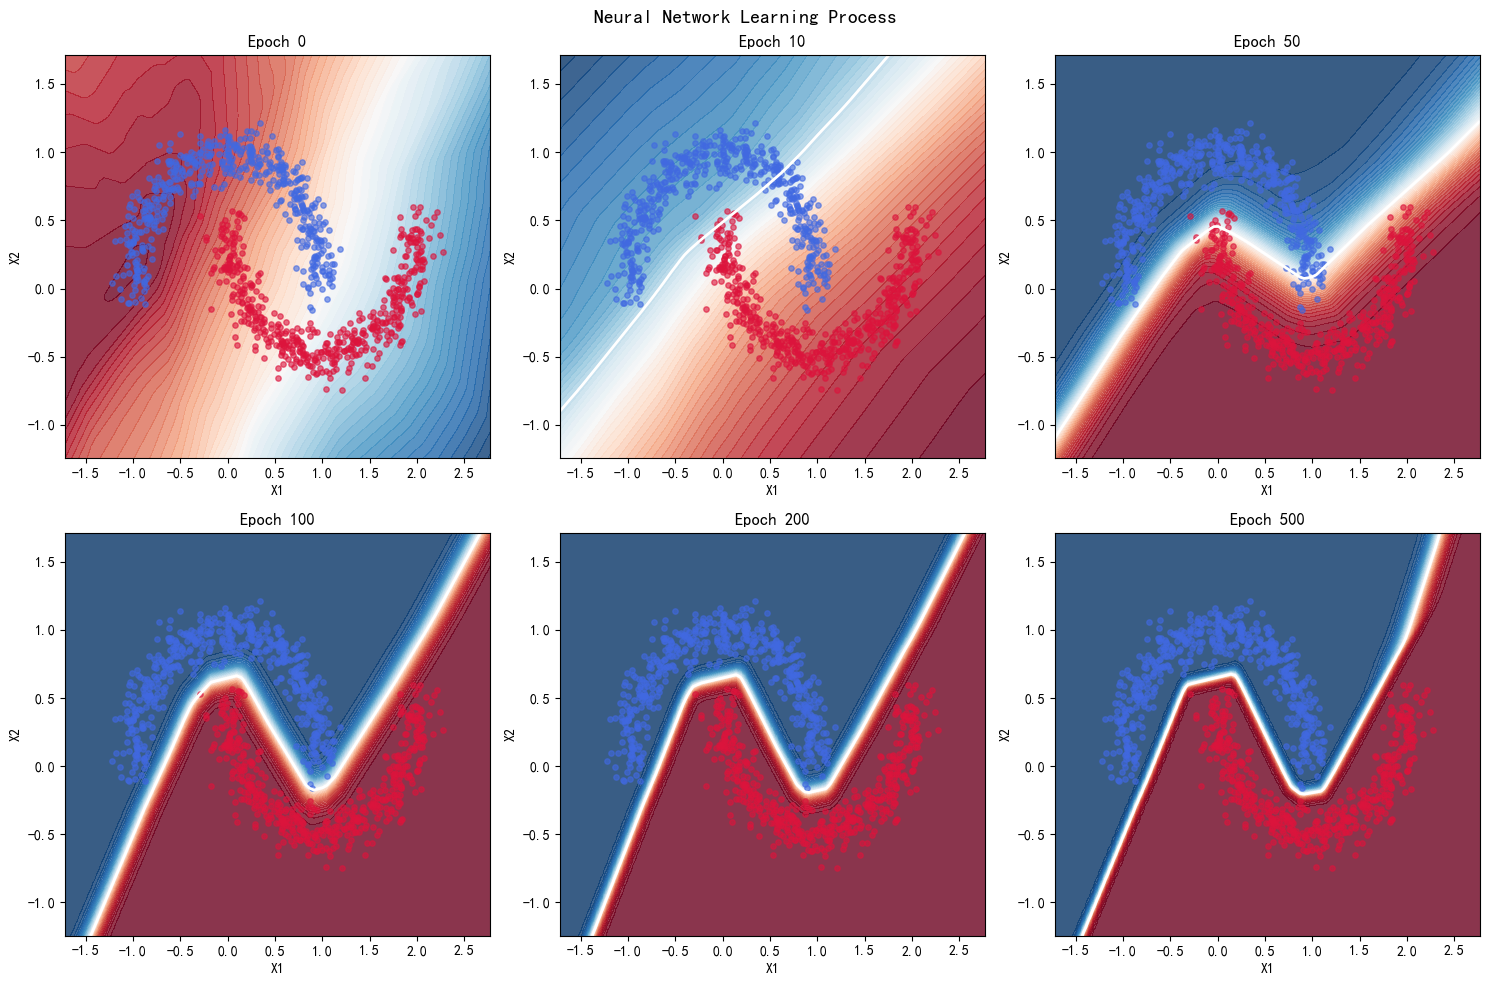


观察：
- Epoch 0: 随机初始化，边界是乱的
- Epoch 10-50: 开始形成边界雏形
- Epoch 100-200: 边界越来越精确
- Epoch 500: 完美拟合数据分布


In [11]:
# 重新初始化模型
model_viz = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_viz.parameters(), lr=0.01)

# 记录不同epoch的决策边界
epochs_to_plot = [0, 10, 50, 100, 200, 500]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# 创建网格用于绘图
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 100),
    np.linspace(y_min, y_max, 100)
)
grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

plot_idx = 0

for epoch in range(501):
    # 绘制特定epoch的决策边界
    if epoch in epochs_to_plot:
        with torch.no_grad():
            Z = model_viz(grid_points).numpy().reshape(xx.shape)
        
        ax = axes[plot_idx]
        ax.contourf(xx, yy, Z, levels=50, cmap='RdBu_r', alpha=0.8)
        ax.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=2)
        ax.scatter(X[y==0, 0], X[y==0, 1], c='royalblue', s=15, alpha=0.6)
        ax.scatter(X[y==1, 0], X[y==1, 1], c='crimson', s=15, alpha=0.6)
        ax.set_title(f'Epoch {epoch}')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        plot_idx += 1
    
    # 训练步骤
    y_pred = model_viz(X_tensor)
    loss = criterion(y_pred, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.suptitle('Neural Network Learning Process', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n观察：")
print("- Epoch 0: 随机初始化，边界是乱的")
print("- Epoch 10-50: 开始形成边界雏形")
print("- Epoch 100-200: 边界越来越精确")
print("- Epoch 500: 完美拟合数据分布")

---

## 6. 挑战升级：尝试更复杂的数据

让我们试试同心圆数据集，看看神经网络能否处理！

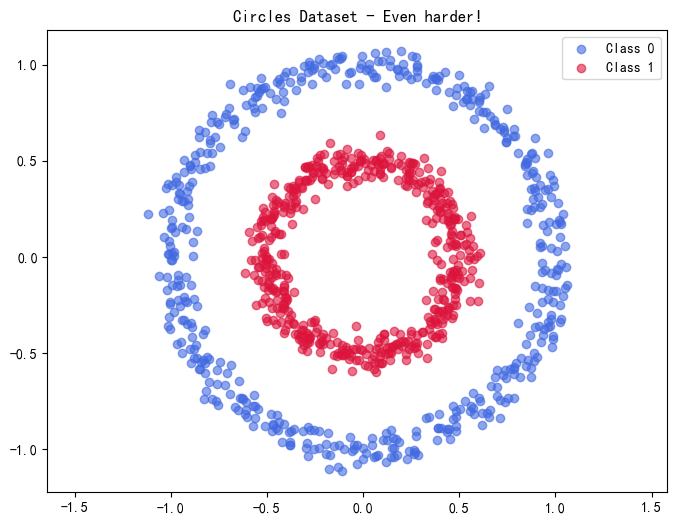


这个数据集需要一个封闭的圆形边界！
神经网络能做到吗？让我们训练看看...


In [12]:
# 生成同心圆数据
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=42)
X_circles_tensor = torch.FloatTensor(X_circles)
y_circles_tensor = torch.FloatTensor(y_circles).reshape(-1, 1)

# 可视化
plt.figure(figsize=(8, 6))
plt.scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], c='royalblue', label='Class 0', alpha=0.6)
plt.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], c='crimson', label='Class 1', alpha=0.6)
plt.title('Circles Dataset - Even harder!')
plt.legend()
plt.axis('equal')
plt.show()

print("\n这个数据集需要一个封闭的圆形边界！")
print("神经网络能做到吗？让我们训练看看...")

训练中...
Epoch 200: Loss=0.0000, Accuracy=100.0%
Epoch 400: Loss=0.0000, Accuracy=100.0%
Epoch 600: Loss=0.0000, Accuracy=100.0%
Epoch 800: Loss=0.0000, Accuracy=100.0%
Epoch 1000: Loss=0.0000, Accuracy=100.0%


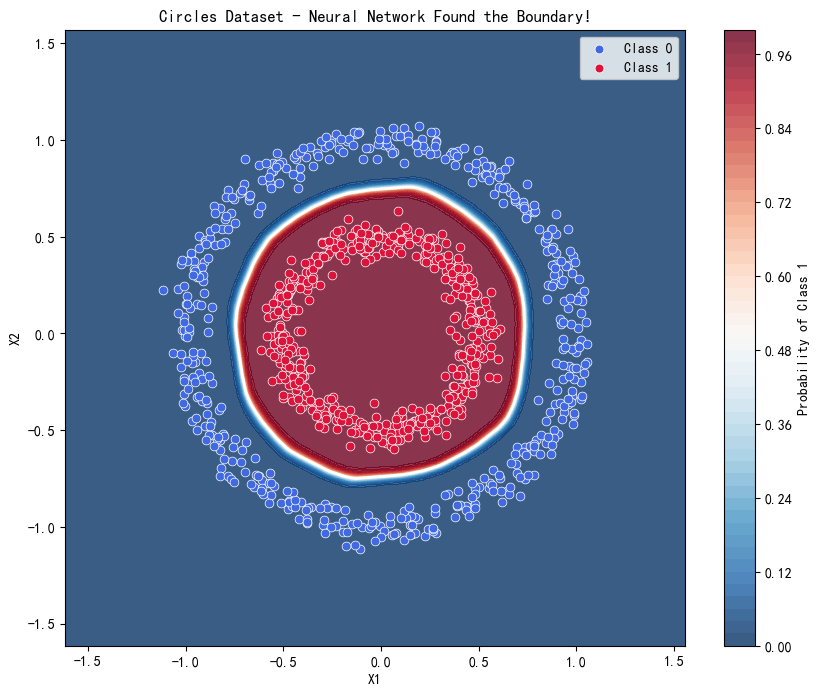


神经网络成功学会了画圆形边界！


In [13]:
# 训练新模型处理同心圆数据
model_circles = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_circles.parameters(), lr=0.01)

# 训练
print("训练中...")
for epoch in range(1000):
    y_pred = model_circles(X_circles_tensor)
    loss = criterion(y_pred, y_circles_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 200 == 0:
        with torch.no_grad():
            acc = ((y_pred > 0.5).float() == y_circles_tensor).sum() / len(y_circles_tensor) * 100
        print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Accuracy={acc:.1f}%")

# 绘制决策边界
plot_decision_boundary(model_circles, X_circles, y_circles, 
                       title="Circles Dataset - Neural Network Found the Boundary!")

print("\n神经网络成功学会了画圆形边界！")

---

## 本章总结

1. **神经网络的本质**
   - 就是一堆可学习的数字（权重和偏置）
   - 通过矩阵运算和激活函数，可以拟合复杂的边界

2. **训练的四步循环** (记住这个！)
   ```python
   y_pred = model(X)              # Forward: 前向传播
   loss = criterion(y_pred, y)    # Loss: 计算损失
   loss.backward()                # Backward: 反向传播（计算梯度）
   optimizer.step()               # Step: 更新参数
   ```

3. **为什么需要神经网络**
   - 能处理线性不可分的数据
   - 自动学习复杂的决策边界
   - 这就是"深度学习"的威力



---

## 思考

1. **修改网络结构**：尝试增加或减少隐藏层的神经元数量，观察对结果的影响
2. **修改学习率**：把 `lr=0.01` 改成 `0.001` 或 `0.1`，观察训练速度的变化
3. **增加噪声**：在 `make_moons` 中把 `noise=0.1` 改成 `0.3`，网络还能学好吗？
4. **思考题**：如果完全去掉 `ReLU` 激活函数会怎样？（提示：线性变换的组合还是线性变换）

In [ ]:
# 练习空间：在这里尝试你的实验

